## Imports

In [1]:
import sys
from pathlib import Path

import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

In [2]:
submission_path = Path("../XTXStarterKit/").as_posix()
if submission_path not in sys.path:
    sys.path.insert(0, submission_path)

In [3]:
import python.utils
import python.model

In [4]:
pd.set_option("max_columns", 10000)
pd.set_option("max_rows", 10000)

In [5]:
%load_ext autoreload
%autoreload 2

## Parameters

## Workspace

In [6]:
!ls ../data/

data-training.csv.gz


In [7]:
data_training = pd.read_csv("../data/data-training.csv.gz")

In [8]:
display(data_training.head(2))
print(len(data_training))

askRate0  askRate1  askRate2  askRate3  askRate4  askRate5  askRate6  \
0    1619.5    1620.0    1621.0       NaN       NaN       NaN       NaN   
1    1619.5    1620.0    1621.0    1621.5       NaN       NaN       NaN   

   askRate7  askRate8  askRate9  askRate10  askRate11  askRate12  askRate13  \
0       NaN       NaN       NaN        NaN        NaN        NaN        NaN   
1       NaN       NaN       NaN        NaN        NaN        NaN        NaN   

   askRate14  askSize0  askSize1  askSize2  askSize3  askSize4  askSize5  \
0        NaN       1.0      10.0      24.0       NaN       NaN       NaN   
1        NaN       1.0      10.0      24.0       5.0       NaN       NaN   

   askSize6  askSize7  askSize8  askSize9  askSize10  askSize11  askSize12  \
0       NaN       NaN       NaN       NaN        NaN        NaN        NaN   
1       NaN       NaN       NaN       NaN        NaN        NaN        NaN   

   askSize13  askSize14  bidRate0  bidRate1  bidRate2  bidRate3  bidRate4  \
0        NaN        NaN    1615.0    1614.0    1613.0    1612.0    1611.0   
1        NaN        NaN    1615.0    1614.0    1613.0    1612.0    1611.0   

   bidRate5  bidRate6  bidRate7  bidRate8  bidRate9  bidRate10  bidRate11  \
0    1610.0    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0   
1    1610.0    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0   

   bidRate12  bidRate13  bidRate14  bidSize0  bidSize1  bidSize2  bidSize3  \
0     1601.5     1601.0     1600.0       7.0      10.0       1.0      10.0   
1     1601.5     1601.0     1600.0       7.0      10.0       1.0      10.0   

   bidSize4  bidSize5  bidSize6  bidSize7  bidSize8  bidSize9  bidSize10  \
0      20.0       3.0      20.0      27.0      11.0      14.0       35.0   
1      20.0       3.0      20.0      27.0      11.0      14.0       35.0   

   bidSize11  bidSize12  bidSize13  bidSize14    y  
0       10.0        1.0       10.0       13.0 -0.5  
1       10.0        1.0       10.0       13.0 -0.5

2999999


In [9]:
data_training = python.utils.fix_input_df(data_training)

In [10]:
display(data_training.head(2))
print(len(data_training))

askRate0  askRate1  askRate2  askRate3  askRate4  askRate5  askRate6  \
0    1619.5    1620.0    1621.0    1621.0    1621.0    1621.0    1621.0   
1    1619.5    1620.0    1621.0    1621.5    1621.5    1621.5    1621.5   

   askRate7  askRate8  askRate9  askRate10  askRate11  askRate12  askRate13  \
0    1621.0    1621.0    1621.0     1621.0     1621.0     1621.0     1621.0   
1    1621.5    1621.5    1621.5     1621.5     1621.5     1621.5     1621.5   

   askRate14  askSize0  askSize1  askSize2  askSize3  askSize4  askSize5  \
0     1621.0       1.0      10.0      24.0       0.0       0.0       0.0   
1     1621.5       1.0      10.0      24.0       5.0       0.0       0.0   

   askSize6  askSize7  askSize8  askSize9  askSize10  askSize11  askSize12  \
0       0.0       0.0       0.0       0.0        0.0        0.0        0.0   
1       0.0       0.0       0.0       0.0        0.0        0.0        0.0   

   askSize13  askSize14  bidRate0  bidRate1  bidRate2  bidRate3  bidRate4  \
0        0.0        0.0    1615.0    1614.0    1613.0    1612.0    1611.0   
1        0.0        0.0    1615.0    1614.0    1613.0    1612.0    1611.0   

   bidRate5  bidRate6  bidRate7  bidRate8  bidRate9  bidRate10  bidRate11  \
0    1610.0    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0   
1    1610.0    1607.0    1606.0    1605.0    1604.0     1603.0     1602.0   

   bidRate12  bidRate13  bidRate14  bidSize0  bidSize1  bidSize2  bidSize3  \
0     1601.5     1601.0     1600.0       7.0      10.0       1.0      10.0   
1     1601.5     1601.0     1600.0       7.0      10.0       1.0      10.0   

   bidSize4  bidSize5  bidSize6  bidSize7  bidSize8  bidSize9  bidSize10  \
0      20.0       3.0      20.0      27.0      11.0      14.0       35.0   
1      20.0       3.0      20.0      27.0      11.0      14.0       35.0   

   bidSize11  bidSize12  bidSize13  bidSize14    y  
0       10.0        1.0       10.0       13.0 -0.5  
1       10.0        1.0       10.0       13.0 -0.5

2999999


In [11]:
split_1 = int(len(data_training) * 0.9)

train_df = data_training.iloc[:split_1]
valid_df = data_training.iloc[split_1:]

In [12]:
assert len(train_df) + len(valid_df) == len(data_training)

In [13]:
train_means = train_df.drop("y", axis=1).mean()
train_stds = train_df.drop("y", axis=1).std()
train_maxes = train_df.drop("y", axis=1).max()

In [14]:
dataset = python.model.XTXDataset(train_df.values)

In [15]:
len(dataset)

2699990

In [16]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset


class XTXDataset(Dataset):
    max_values = None

    def __init__(self, data, num_previous=10) -> None:
        super().__init__()
        self.data = data
        self.num_previous = num_previous

    def __len__(self):
        return self.data.shape[0] - self.num_previous

    def __getitem__(self, index):
        chunk = self.data[index : index + self.num_previous + 1, :].copy()
        inputs = chunk[:, :-1]
        inputs = inputs / self.max_values
        inputs = inputs[:-1, :] - inputs[1:, :]
    
        targets = chunk[1:, -1:]
        return inputs, targets


class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_previous):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_previous, d_model)
        position = torch.arange(0, max_previous).unsqueeze(1).to(torch.float32)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).to(torch.float32)
            * -(np.log(max_previous * 10) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = torch.flip(pe, (0,))
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, -x.size(1) :]
        return self.dropout(x)


class XTXModel(nn.Module):
    def __init__(
        self,
        input_size,
        d_model=512,
        nhead=8,
        num_encoder_layers=6,
        dim_feedforward=2048,
        dropout=0.1,
        num_previous=100,
    ):
        super().__init__()

        self.embedding = nn.Sequential(
            nn.Linear(input_size, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model),
            nn.LayerNorm(d_model),
        )

        self.pe = PositionalEncoding(d_model, dropout, num_previous)

        self.input_norm = nn.BatchNorm1d(num_previous)

        custom_decoder = nn.MultiheadAttention(
            d_model, num_heads=nhead, dropout=dropout, bias=True
        )
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            custom_decoder=custom_decoder,
        )

        self.dropout_out = nn.Dropout(dropout)
        self.norm_out = nn.BatchNorm1d(num_previous)

        self.linear_out = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(dim_feedforward, 1),
        )

        self.d_model = d_model

    def forward(
        self,
        input,
        src_mask=None,
        src_key_padding_mask=None,
        tgt_key_padding_mask=None,
        tgt_attn_mask=None,
    ):
        input = self.embedding(input)
        input = self.input_norm(input)
        input = self.pe(input)
        src = input.transpose(0, 1)

        if src.size(2) != self.d_model:
            raise RuntimeError(
                "the feature number of src and tgt must be equal to d_model"
            )

        memory = self.transformer.encoder(
            src, mask=src_mask, src_key_padding_mask=src_key_padding_mask
        )
        src = src + self.dropout_out(memory)
        output = src.transpose(0, 1)
        output = self.norm_out(output)
        output = self.linear_out(output)
        return output

In [17]:
# XTXDataset.means = train_means.astype(np.float32).values
# XTXDataset.stds = train_stds.astype(np.float32).values

In [18]:
XTXDataset.max_values = train_maxes.astype(np.float32).values

In [19]:
pe = PositionalEncoding(128, 0.1, 1000)

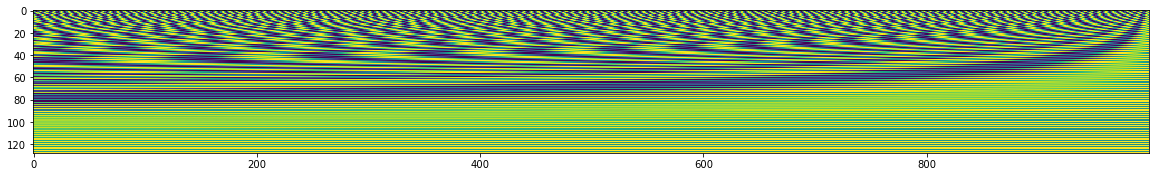

In [20]:
fg, ax = plt.subplots(figsize=(20, 10))
plt.imshow(pe.pe.squeeze().data.numpy().T)

In [21]:
device = torch.device("cuda:0")

net = XTXModel(60, d_model=32, nhead=8, num_encoder_layers=6, dim_feedforward=128, num_previous=100).to(device)
criterion = nn.MSELoss(reduction="sum")
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [22]:
train_dataset = XTXDataset(train_df.astype(np.float32).values, 100)
valid_dataset = XTXDataset(valid_df.astype(np.float32).values, 100)

Epoch: 0
-0.091813
0.001445
-0.002424
-0.001050
0.001894
0.001587
-0.046399
-0.015673
-0.012443
0.003431
0.004241
0.001373
0.000759
-0.003581
-0.002850
-0.001046
0.002869
0.003165
-0.002376
0.003103
-0.004559
0.003589
0.000697
0.003735
-0.000322
0.004446
0.004982
Validation: -0.004081


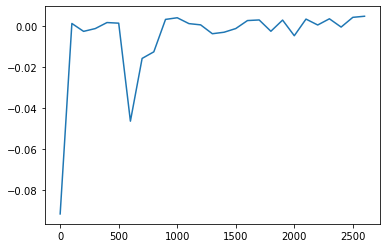

Epoch: 1
0.004025
0.004271
0.013244
0.003521
0.006194
0.009538
0.007434
0.006024
0.005634
-0.001432
0.008522
-0.000027
0.008609
-0.006148
0.005527
0.004905
0.001809
0.002332
-0.001532
0.000291
0.010853
0.001199
0.000648
0.009692
0.004404
-0.001140
0.011828
Validation: -0.002069


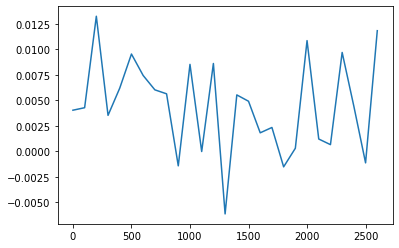

Epoch: 2
-0.000647
0.002096
0.018580
0.007195
0.017808
-0.002225
0.005723
-0.004514
0.008298
0.020442
0.001523
0.019495
0.007774
0.014983
-0.000756
0.007374
0.005603
0.011173
0.009105
-0.000539
0.001459
0.006561
0.011288
0.024689
0.004449
-0.004632
0.002637
Validation: -0.009645


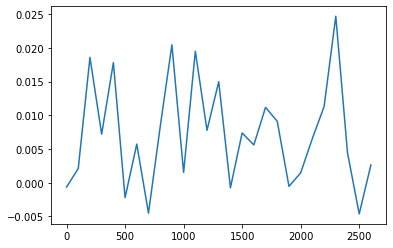

Epoch: 3
0.003719
0.021095
0.010332
0.006310
0.017282
0.029761
0.013848
0.022952
0.040341
0.014107
0.009207
0.017895
0.019713
0.036666
0.044287
0.018838
0.039454
0.031360
0.031742
0.016401
0.020921
0.051405
0.047090
0.045362
0.033863
0.018313
-0.010943
Validation: -0.019161


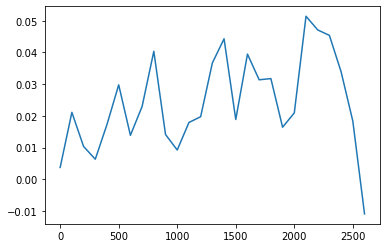

Epoch: 4
0.036314
0.037299
0.038848
0.049168
0.023109
0.029319
0.049129
0.027239
0.022073
0.032977
0.019357
0.034545
0.039180
0.056963
0.050154
0.056722
0.053791
0.019671
0.096381
0.040083
0.013069
0.047435
0.080266
0.026766
0.007934
0.075692
0.057553
Validation: -0.049539


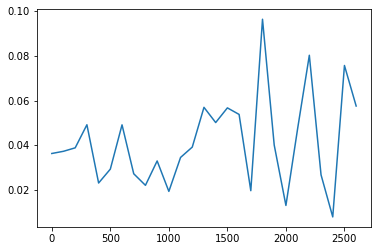

Epoch: 5
0.059010
0.076325
0.054501
0.031791
0.058948
0.034705
0.033196
0.034852
0.014554
0.079495
0.062485
0.082544
0.058416
0.044469
0.022434
0.033657
0.045122
0.077955
0.030604
0.060290
0.046529
0.093526
0.058118
0.039950
0.063481
0.054491
0.086199
Validation: -0.074160


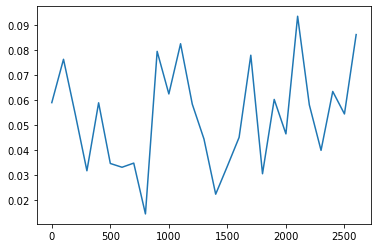

Epoch: 6
0.048790
0.082681
0.057929
0.059022
0.057170
0.071173
0.056999
0.054228
0.052248
0.074008
0.064645
0.061675
0.105386
0.055373
0.091145
0.031623
0.060928
0.050020
0.118252
0.034577
0.044288
0.069217
0.036720
0.029440
0.044482
0.054361
0.079505
Validation: -0.060993


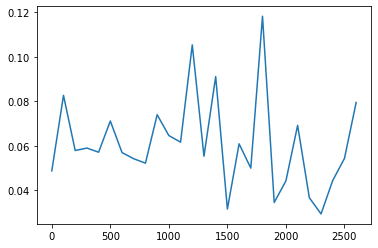

Epoch: 7
0.079775
0.058016
0.093717
0.066405
0.078462
0.062850
0.090935
0.114338
0.075531
0.093457
0.102792
0.045419
0.084389
0.085223
0.076390
0.105446
0.057726
0.112406
0.067698
0.119367
0.085163
0.039850
0.069535
0.035298
0.114178
0.075127
0.085959
Validation: -0.112559


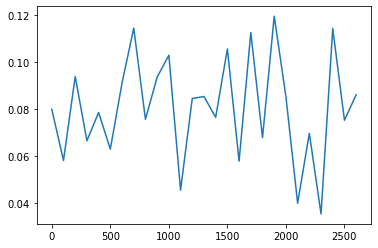

Epoch: 8
0.075560
0.103484
0.122627
0.148568
0.083667
0.088481
0.072184
0.065557
0.087636
0.069337
0.065814
0.091769
0.125388
0.054594
0.070975
0.089528
0.067717
0.098352
0.133770
0.101547
0.100243
0.133712
0.113941
0.134118
0.112250
0.106522
0.105285
Validation: -0.102964


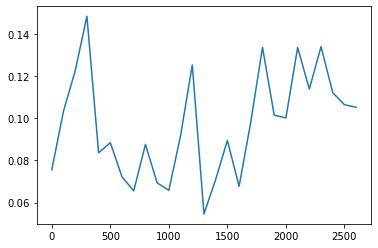

Epoch: 9
0.054557
0.082740
0.124819
0.110317
0.154463
0.066909
0.104495
0.065340
0.080064
0.093296
0.134727
0.106941
0.064128
0.104687
0.080248
0.118166
0.127115
0.120673
0.130224
0.088264
0.175014
0.071771
0.105693
0.115618
0.059470
0.066163
0.099820
Validation: -0.130805


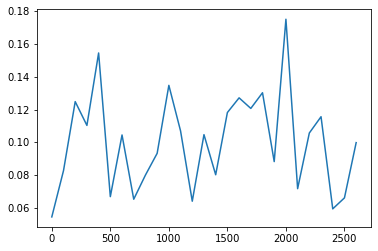

Epoch: 10
0.093960
0.151174
0.111897
0.107287
0.125281
0.080427
0.143264
0.106068
0.144131
0.140779
0.115531
0.123526
0.066189
0.077182
0.197471
0.106649
0.142429
0.115175
0.102531
0.098548
0.083588
0.093813
0.193593
0.155343
0.106884
0.162834
0.133041
Validation: -0.287554


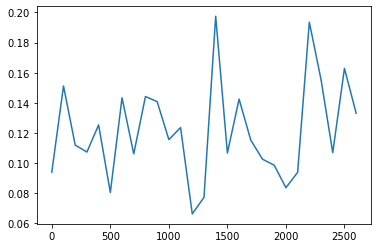

Epoch: 11
0.105944
0.151007
0.114032
0.131407
0.129862
0.153616
0.097878
0.110879
0.119474
0.151982
0.172058
0.087744
0.071208
0.124101
0.168798
0.095252
0.140501
0.119563
0.111866
0.124969
0.092654
0.077748
0.141598
0.155901
0.158940
0.172630
0.092975
Validation: -0.159411


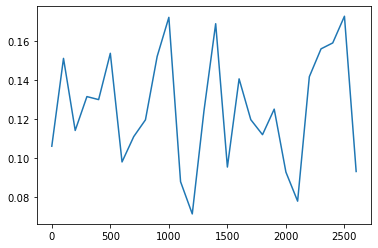

Epoch: 12
0.154709
0.165243
0.102225
0.074367
0.144432
0.125822
0.176743
0.116018
0.175676
0.139360
0.132022
0.120579
0.137526
0.125180
0.186425
0.092069
0.058413
0.139826
0.144035
0.173662
0.173424
0.208711
0.176032
0.141669
0.088406
0.201798
0.160669
Validation: -0.105624


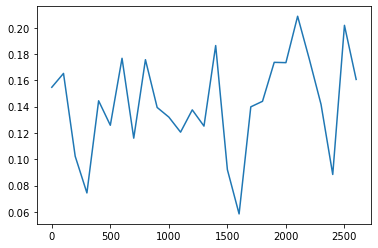

Epoch: 13
0.140412
0.144780
0.169977
0.177480
0.126673
0.194494
0.173798
0.159883
0.179964
0.136809
0.112560
0.174725
0.100088
0.099873
0.129185
0.167286
0.203122
0.165318
0.180728
0.140813
0.092951
0.128806
0.167681
0.156636
0.144984
0.118204
0.164852
Validation: -0.212176


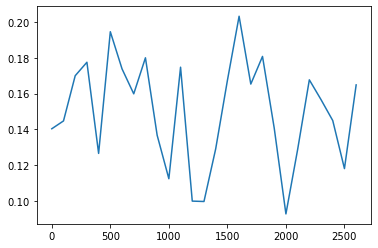

Epoch: 14
0.138058
0.223868
0.220293
0.213213
0.143818
0.184647
0.180069
0.174833
0.147050
0.143292
0.140586
0.141774
0.157948
0.143517
0.185686
0.110549
0.106044
0.163457
0.153115
0.204040
0.160426
0.202635
0.154745
0.197146
0.145445
0.158904
0.172300
Validation: -0.146408


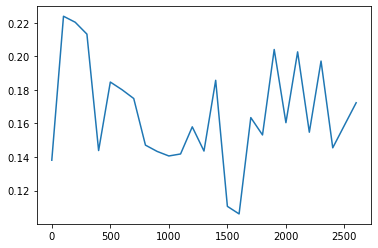

Epoch: 15
0.211532
0.182527
0.151390
0.204520
0.144853
0.147631
0.143681
0.176366
0.166363
0.162507
0.159363
0.167364
0.219330
0.210052
0.179545
0.127710
0.207595
0.141202
0.180865
0.252867
0.139214
0.196390
0.162326
0.156595
0.191708
0.174486
0.142408
Validation: -0.145366


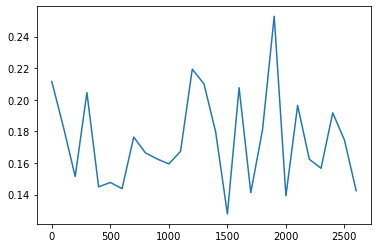

Epoch: 16
0.097108
0.193274
0.173571
0.246124
0.211746
0.131703
0.154347
0.087710
0.162553
0.164204
0.134339
0.173746
0.193266
0.179105
0.194037
0.180872
0.172452
0.230646
0.190265
0.215485
0.197177
0.146271
0.174024
0.129773
0.106744
0.159026
0.168919
Validation: -0.307657


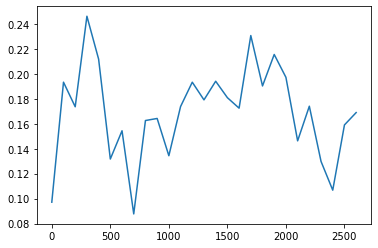

Epoch: 17
0.197931
0.079232
0.113071
0.143262
0.147645
0.191739
0.192609
0.202424
0.185662
0.133261
0.213158
0.197268
0.195226
0.208215
0.150762
0.235352
0.211869
0.143950
0.131974
0.205114
0.184959
0.215156
0.151073
0.208753
0.152570
0.167125
0.173826
Validation: -0.219370


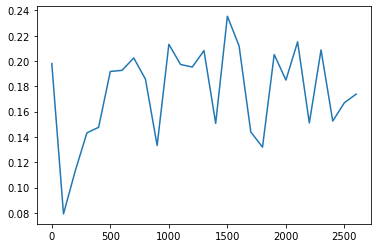

Epoch: 18
0.152588
0.170629
0.169997
0.196485
0.235127
0.187791
0.170689
0.225679
0.163145
0.160555
0.194501
0.181094
0.139673
0.168975
0.219924
0.253883
0.180936
0.270014
0.197481
0.158821
0.196294
0.192970
0.170238
0.173453
0.170240
0.169269
0.187270
Validation: -0.285772


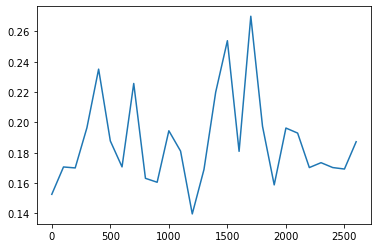

Epoch: 19
0.145718
0.159610
0.206023
0.192743
0.166883
0.181296
0.207416
0.191951
0.201502
0.155269
0.146124
0.146933
0.214878
0.101523
0.238574
0.129001
0.165036
0.220222
0.170042
0.181618
0.211232
0.236927
0.165104
0.206033
0.218807
0.149974
0.201902
Validation: -0.268662


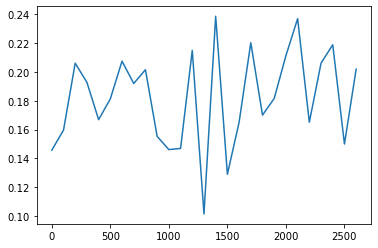

Epoch: 20
0.184502
0.237163
0.139916
0.191141
0.204546
0.221436
0.218862
0.205019
0.182457
0.162875
0.147864
0.145434
0.158424
0.187830
0.184007
0.146112
0.128507
0.150466
0.148274
0.182473
0.177781
0.213028
0.195088
0.173772
0.177778
0.243628
0.186738
Validation: -0.228869


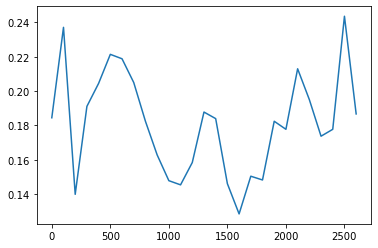

Epoch: 21
0.185199
0.180175
0.163899
0.225452
0.279027
0.245713
0.165661
0.220973
0.226663
0.263667
0.227473
0.201874
0.204710
0.169730
0.202870
0.203084
0.178480
0.187416
0.153364
0.195413
0.173596
0.204499
0.246215
0.161247
0.207541
0.211912
0.155248
Validation: -0.450823


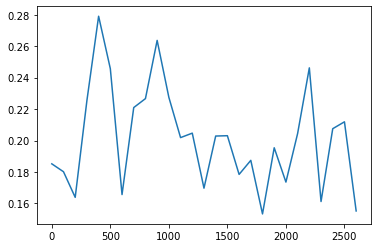

Epoch: 22
0.267630
0.159614
0.208317
0.201817
0.228654
0.192609
0.186109
0.156479
0.184974
0.227049
0.260253
0.177978
0.266496
0.194635
0.210460
0.209685
0.249778
0.147368
0.178688
0.187621
0.247854
0.165251
0.210577
0.217340
0.216766
0.215936
0.187100
Validation: -0.204707


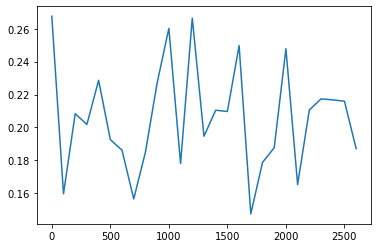

Epoch: 23
0.156183
0.192970
0.179629
0.192680
0.215942
0.183534
0.215895
0.213318
0.182755
0.151223
0.202065
0.219058
0.248195
0.283707
0.268987
0.207233
0.238168
0.191544
0.177065
0.200004
0.178747
0.175569
0.135685
0.197231
0.210735
0.135442
0.247051
Validation: -0.406086


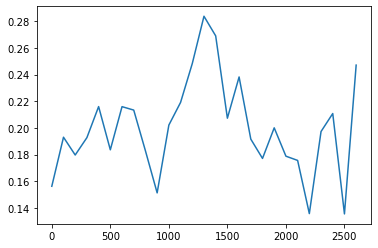

Epoch: 24
0.225222
0.192532
0.306402
0.311560
0.236677
0.148475
0.209827
0.245508
0.221243
0.235207
0.215207
0.201216
0.221714
0.213791
0.169638
0.224936
0.198908
0.235369
0.184400
0.234859
0.228304
0.160687
0.251149
0.188403
0.199379
0.219760
0.260217
Validation: -0.213345


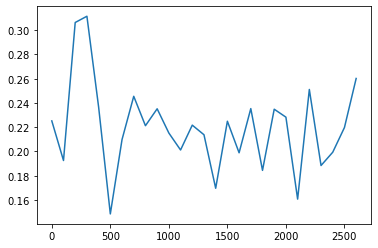

Epoch: 25
0.173354
0.258331
0.207894
0.198034
0.171967
0.227547
0.242066
0.268290
0.214482
0.220800
0.200558
0.223430
0.217063
0.212164
0.247278
0.255404
0.208134
0.157878
0.258244
0.248265
0.199242
0.203647
0.264882
0.210651
0.239019
0.230687
0.217460
Validation: -0.212637


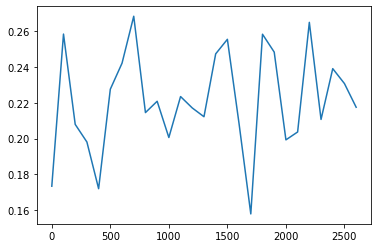

Epoch: 26
0.206563
0.199346
0.183289
0.332430
0.226261
0.223149
0.206040
0.199632
0.236160
0.285062
0.197430
0.203334
0.200952
0.148887
0.204871
0.233092
0.249665
0.282887
0.211693
0.228192
0.195899
0.187138
0.186471
0.197355
0.253931
0.237060
0.198572
Validation: -0.222857


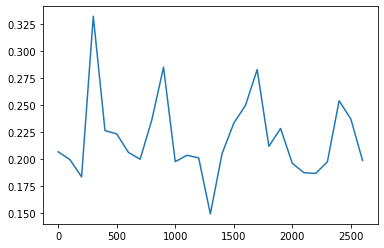

Epoch: 27
0.237371
0.221417
0.194588
0.221891
0.227004
0.258729
0.235151
0.226846
0.254573
0.203202
0.246980
0.231716
0.244011
0.204075
0.184819
0.197410
0.231174
0.187898
0.270706
0.164240
0.244571
0.310914
0.199176
0.230026
0.186471
0.275647
0.217863
Validation: -0.204790


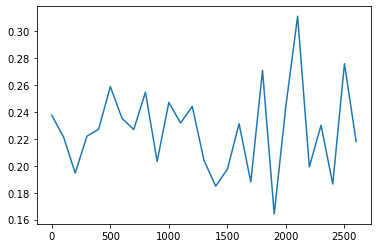

Epoch: 28
0.243510
0.201957
0.147309
0.240282
0.218745
0.239312
0.199307
0.270042
0.223375
0.180585
0.220414
0.217667
0.163333
0.221207
0.180326
0.227394
0.233611
0.164608
0.227955
0.224885
0.254021
0.192405
0.192280
0.254545
0.276498
0.288114
0.248306
Validation: -0.267085


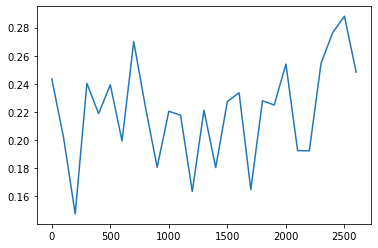

Epoch: 29
0.218413
0.209381
0.191670
0.237878
0.275841
0.197070
0.238282
0.218183
0.209929
0.288917
0.236924
0.242940
0.244562
0.219226
0.267410
0.240910
0.194797
0.197178
0.261644
0.242307
0.218472
0.220574
0.225617
0.228833
0.220761
0.270798
0.243506
Validation: -0.261663


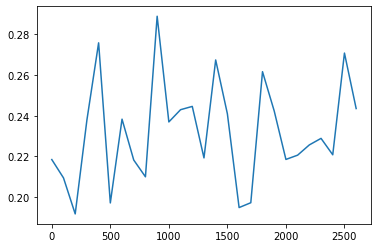

Epoch: 30
0.191020
0.283868
0.265303
0.237619
0.164847
0.292105
0.186885
0.240491
0.249452
0.200685
0.227036
0.165286
0.184187
0.267136
0.186627
0.238056
0.157105
0.263033
0.273030
0.276487
0.276712
0.229103
0.238402
0.248603
0.288532
0.259262
0.229481
Validation: -0.276234


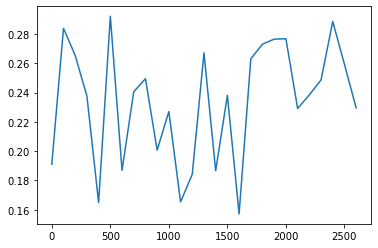

Epoch: 31
0.232491
0.223332
0.219742
0.195142
0.204442
0.300945
0.226187
0.196299
0.178736
0.221915
0.212809
0.261911
0.189835
0.271093
0.236659
0.255169
0.237941
0.277871
0.265642
0.287140
0.207390
0.222064
0.223920
0.285449
0.308696
0.209547
0.221667
Validation: -0.239377


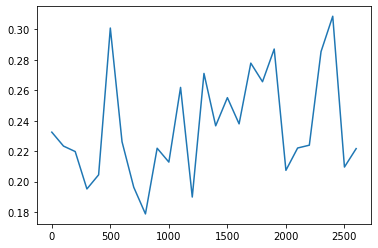

Epoch: 32
0.160715
0.199901
0.229625
0.298569
0.229860
0.227443
0.226606
0.287124
0.312637
0.279732
0.303306
0.197008
0.288644
0.209427
0.288837
0.292682
0.240568
0.225292
0.273043
0.232631
0.242416
0.274636
0.173844
0.301564
0.171100
0.177601
0.246681
Validation: -0.273077


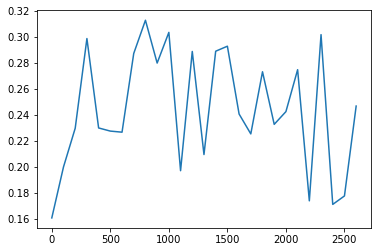

Epoch: 33
0.274617
0.217602
0.266154
0.279646
0.278037
0.211700
0.240543
0.272911
0.251466
0.236689
0.175072
0.288582
0.217910
0.221122
0.238600
0.257484
0.216446
0.209622
0.215127
0.208716
0.185218
0.226915
0.329260
0.207386
0.323538
0.275749
0.285773
Validation: -0.296081


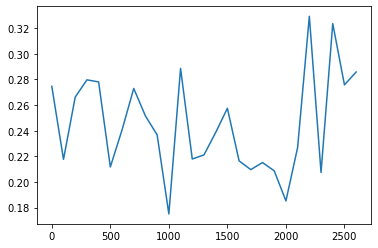

Epoch: 34
0.216054
0.269415
0.241897
0.239260
0.213424
0.246303
0.320590
0.245401
0.287073
0.256097
0.253416
0.261921
0.237880
0.269825
0.183846
0.304011
0.290562
0.248827
0.256083
0.226152
0.327706
0.283733
0.329971
0.240407
0.210163
0.312278
0.290875
Validation: -0.237661


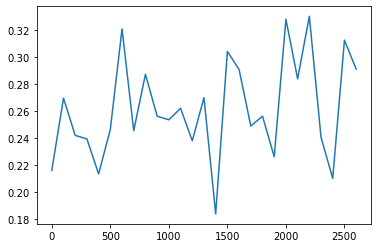

Epoch: 35
0.312620
0.264328
0.234599
0.251259
0.269686
0.225890
0.227287
0.315592
0.274749
0.291417
0.291230
0.320412
0.289620
0.176754
0.263399
0.284290
0.289210
0.332604
0.192876
0.212715
0.225113
0.242990
0.291087
0.275984
0.175441
0.253040
0.252636
Validation: -0.233370


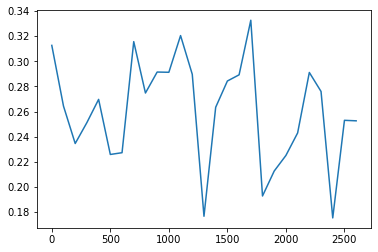

Epoch: 36
0.297334
0.293838
0.221378
0.311872
0.255803
0.253832
0.211327
0.196514
0.248362
0.230944
0.275223
0.318468
0.238887
0.239353
0.227036
0.278604
0.269008
0.191295
0.284911
0.305055
0.263981
0.290032
0.221508
0.208366
0.263504
0.233233
0.315426
Validation: -0.314728


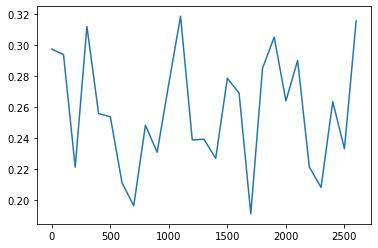

Epoch: 37
0.264606
0.227147
0.186353
0.275482
0.200536
0.243550
0.219784
0.259046
0.225711
0.350508
0.230748
0.295157
0.300068
0.284986
0.207281
0.256840
0.208650
0.231225
0.311653
0.266417
0.293311
0.269842
0.202285
0.229902
0.259400
0.276163
0.296153
Validation: -0.326902


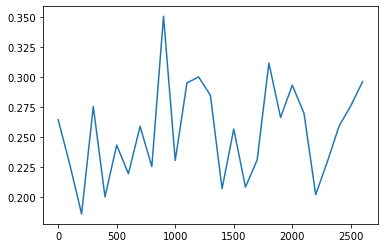

Epoch: 38
0.269434
0.299674
0.293908
0.158290
0.307561
0.258517
0.277887
0.234528
0.251764
0.208959
0.261592
0.277129
0.280297
0.274557
0.249885
0.295673
0.279475
0.261798
0.226931
0.307242
0.239627
0.243143
0.242749
0.237681
0.289099
0.250645
0.279058
Validation: -0.384649


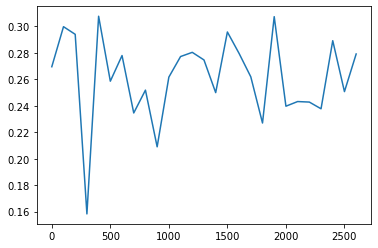

Epoch: 39
0.271675
0.187223
0.273581
0.339052
0.282418
0.249950
0.276431
0.293081
0.250551
0.224437
0.245454
0.248211
0.251289
0.215600
0.276467
0.193174
0.353279
0.274488
0.228711
0.308815
0.286256
0.236951
0.241785
0.310603
0.319005
0.307592
0.257030
Validation: -0.351350


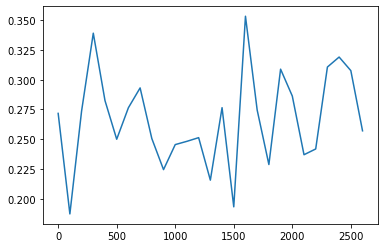

Epoch: 40
0.254832
0.305023
0.247645
0.288130
0.264988
0.281919
0.278400
0.226517
0.214177
0.354295
0.342021
0.323073
0.282143
0.275978
0.266638
0.309928
0.226793
0.332049
0.244018
0.268489
0.265581
0.221560
0.324491
0.228418
0.217035
0.252001
0.354874
Validation: -0.197637


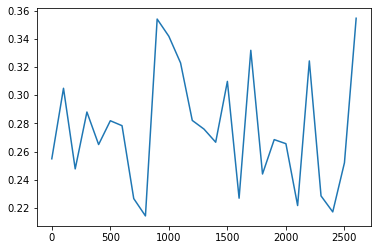

Epoch: 41
0.272425
0.296137
0.247954
0.237873
0.248641
0.281824
0.215006
0.245997
0.261748
0.290830
0.258059
0.303809
0.297260
0.297480
0.247168
0.313010
0.261127
0.265308
0.306011
0.181238
0.232179
0.259177
0.312874
0.290543
0.260305
0.329699
0.300213
Validation: -0.196310


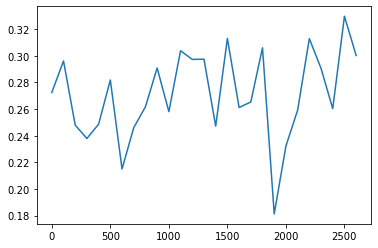

Epoch: 42
0.239568
0.317210
0.185993
0.292861
0.308440
0.312898
0.297689
0.202526
0.248131
0.213667
0.341612
0.256448
0.305008
0.211914
0.309501
0.248103
0.299646
0.314963
0.328789
0.270540
0.278760
0.286674
0.213999
0.294692
0.303598
0.293029
0.307831
Validation: -0.315141


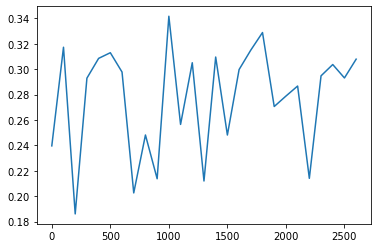

Epoch: 43
0.305571
0.216283
0.275799
0.297228
0.275071
0.305842
0.270878
0.341319
0.253033
0.253633
0.208344
0.289061
0.290727
0.306746
0.296747
0.251075
0.263186
0.256935
0.312933
0.321502
0.336748
0.275589
0.238229
0.264424
0.295271
0.281007
0.295868
Validation: -0.330160


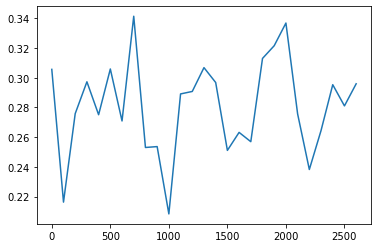

Epoch: 44
0.200497
0.236488
0.260433
0.288270
0.247993
0.281761
0.337106
0.280429
0.288439
0.271524
0.224973
0.349686
0.320865
0.297943
0.289367
0.243885
0.280084
0.340017
0.262052
0.312148
0.273429
0.301393
0.313366
0.250263
0.274095
0.258702
0.295271
Validation: -0.286029


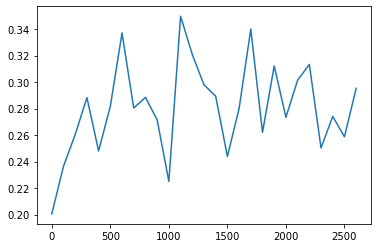

Epoch: 45
0.278987
0.243215
0.231749
0.244136
0.264474
0.269229
0.246519
0.292697
0.269983
0.282648
0.298868
0.249884
0.320050
0.274388
0.316842
0.273639
0.284227
0.307956
0.257655
0.285668
0.399381
0.302466
0.307136
0.242106
0.247667
0.270063
0.277182
Validation: -0.291462


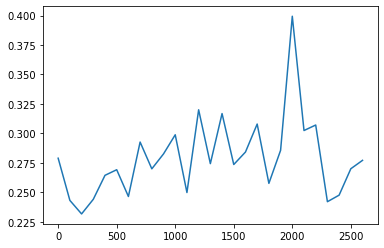

Epoch: 46
0.316833
0.242067
0.291087
0.330567
0.296922
0.251099
0.337980
0.308946
0.269963
0.294635
0.305509
0.323218
0.310799
0.325599
0.274283
0.334961
0.313645
0.327674
0.288464
0.320523
0.250075
0.321421
0.240431
0.312192
0.239449
0.284247
0.316916
Validation: -0.282823


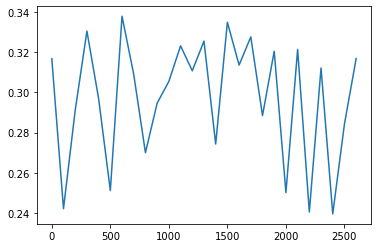

Epoch: 47
0.297597
0.256919
0.330905
0.236133
0.314544
0.295366
0.232536
0.293176
0.304931
0.296927
0.301566
0.307888
0.265082
0.318647
0.242580
0.262012
0.314496
0.198811
0.264058
0.273907
0.274978
0.281662
0.279961
0.275293
0.307207
0.335745
0.268101
Validation: -0.305107


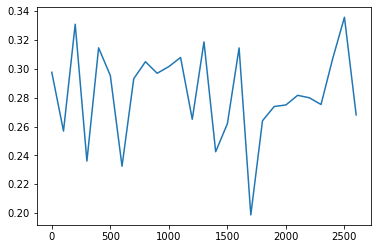

Epoch: 48
0.271272
0.257494
0.294021
0.291034
0.292836
0.304011
0.291258
0.296062
0.333445
0.323903
0.248696
0.297279
0.286975
0.273984
0.321817
0.297853
0.241942
0.314390
0.248400
0.270942
0.277753
0.342365
0.263697
0.359153
0.325768
0.236236
0.311571
Validation: -0.283456


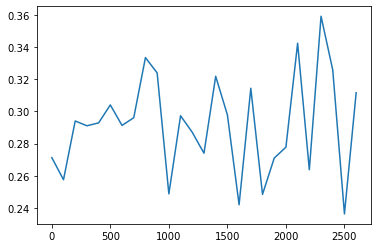

Epoch: 49
0.301317
0.296111
0.352179
0.269010
0.296259
0.292695
0.299777
0.347146
0.261148
0.295919
0.286047
0.275669
0.306463
0.238030
0.265431
0.346254
0.304808
0.328816
0.368224
0.329937
0.282047
0.299769
0.306312
0.261729
0.279731
0.249256
0.288124
Validation: -0.303015


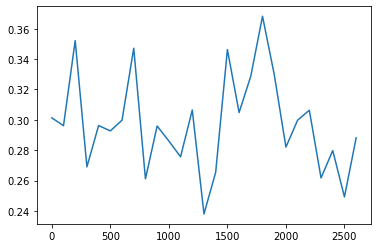

Epoch: 50
0.288529
0.211803
0.309185
0.282810
0.287253
0.197412
0.242372
0.323669
0.280598
0.309654
0.236216
0.303251
0.293876
0.257072
0.264612
0.246999
0.352136
0.262660
0.313063
0.291488
0.276829
0.306716
0.307224
0.272677
0.287938
0.291496
0.301852
Validation: -0.255052


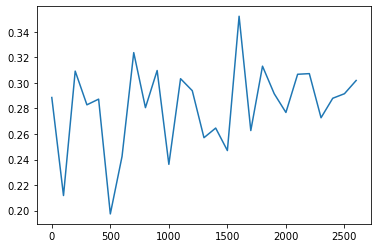

Epoch: 51
0.322755
0.300738
0.332900
0.269952
0.306756
0.328473
0.307123
0.349433
0.208749
0.278564
0.301500
0.300068
0.211207
0.271535
0.293443
0.300903
0.324075
0.343324
0.279588
0.309866
0.301780
0.270291
0.324784
0.286055
0.322962
0.276975
0.371622
Validation: -0.296863


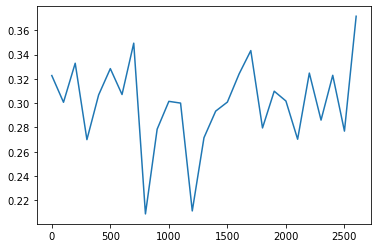

Epoch: 52
0.280450
0.357821
0.251404
0.316019
0.268425
0.322052
0.332102
0.285802
0.340661
0.288200
0.328996
0.219400
0.352529
0.305281
0.326317
0.335881
0.276359
0.312387
0.307655
0.369197
0.315570
0.302622
0.285667
0.288023
0.244298
0.300988
0.269446
Validation: -0.305893


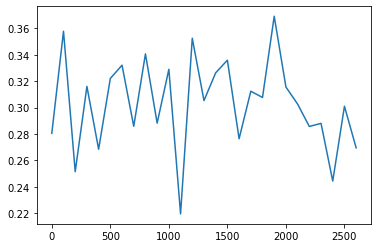

Epoch: 53
0.261753
0.300025
0.308177
0.376109
0.255542
0.275581
0.374732
0.353068
0.284887
0.265436
0.270827
0.308540
0.252609
0.277592
0.236675
0.329143
0.260239
0.332435
0.354832
0.247000
0.341281
0.299475
0.277958
0.341948
0.341560
0.310635
0.278914
Validation: -0.260148


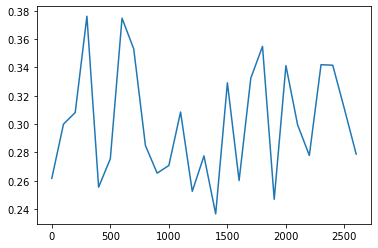

Epoch: 54
0.277660
0.346281
0.281375
0.347884
0.345107
0.367027
0.242668
0.284636
0.317694
0.368925
0.334180
0.260111
0.264526
0.332746
0.326328
0.309073
0.274226
0.276694
0.307284
0.413909
0.270729
0.327695
0.245191
0.299348
0.245669
0.259450
0.303178
Validation: -0.254000


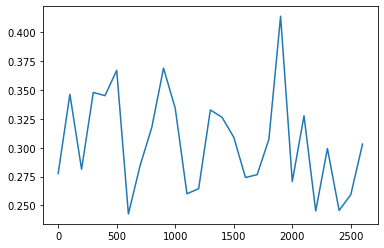

Epoch: 55
0.295604
0.244922
0.265759
0.238388
0.274783
0.241752
0.276902
0.264430
0.358911
0.337561
0.258232
0.339713
0.323004
0.377461
0.304636
0.370017
0.284343
0.293050
0.359987
0.319536
0.282361
0.324565
0.284554
0.339212
0.325297
0.293001
0.266946
Validation: -0.341349


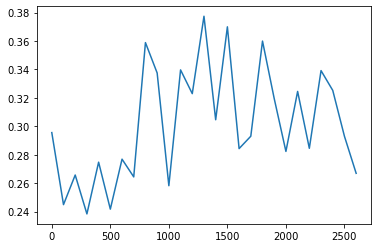

Epoch: 56
0.294634
0.288131
0.299059
0.422138
0.280212
0.275649
0.295630
0.294640
0.256251
0.322522
0.334800
0.233773
0.279399
0.305121
0.332928
0.243611
0.294579
0.287784
0.315295
0.311779
0.321009
0.306640
0.308351
0.234505
0.336259
0.260733
0.336411
Validation: -0.261277


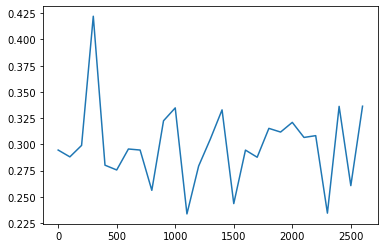

Epoch: 57
0.273095
0.308199
0.309581
0.375352
0.321298
0.343138
0.308239
0.323508
0.362412
0.335264
0.249461
0.303145
0.300479
0.286813
0.326051
0.353954
0.302175
0.310620
0.230469
0.298138
0.299466
0.312978
0.299081
0.391245
0.353935
0.311447
0.247883
Validation: -0.419910


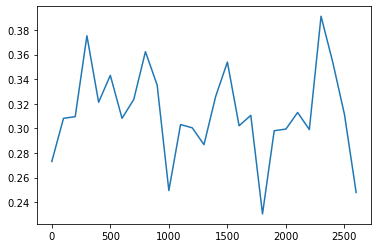

Epoch: 58
0.336685
0.214193
0.321857
0.367995
0.290185
0.285624
0.357134
0.382316
0.273077
0.313634
0.337627
0.309757
0.299505
0.317575
0.293846
0.258692
0.232205
0.291802
0.310562
0.376450
0.279043
0.274017
0.276032
0.259270
0.364863
0.328756
0.210566
Validation: -0.366698


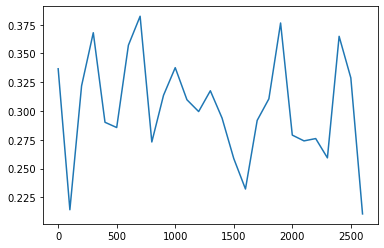

Epoch: 59
0.314669
0.290912
0.316391
0.299720
0.316951
0.309240
0.254356
0.373180
0.299575
0.401370
0.279791
0.304405
0.306547
0.276556
0.266625
0.380404
0.269578
0.352690
0.269560
0.317408
0.339200
0.280442
0.279176
0.308473
0.304039
0.345268
0.317994
Validation: -0.299678


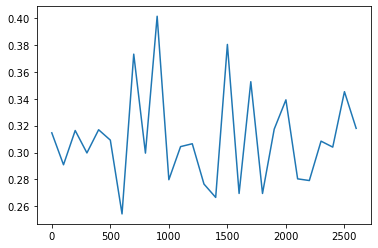

In [23]:
batch_size = 1028
for epoch in range(60):
    print(f"Epoch: {epoch}")
    net.train()
    scores = []
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    for i, batch in enumerate(train_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        out = net(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            last_ys = y[:, -1, :].squeeze()
            last_outs = out[:, -1, :].squeeze()
            score = (
                1 - ((last_ys - last_outs) ** 2).sum() / (last_ys ** 2).sum()
            ).item()
            print(f"{score:.6f}")
            scores.append((i, score))

    net.eval()
    y_list = []
    out_list = []
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    for i, batch in enumerate(valid_loader):
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            out = net(x)

        last_ys = y[:, -1, :].squeeze().to(torch.device("cpu")).data.numpy()
        last_outs = out[:, -1, :].squeeze().to(torch.device("cpu")).data.numpy()
        y_list.append(last_ys)
        out_list.append(last_outs)

    last_ys = np.hstack(y_list)
    last_outs = np.hstack(out_list)
    score = (
        1 - ((last_outs - last_ys) ** 2).sum() / (last_ys ** 2).sum()
    ).item()
    print(f"Validation: {score:.6f}")

    plt.plot([t[0] for t in scores], [t[1] for t in scores])
    plt.show()

In [24]:
    y_list = []
    out_list = []
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    for i, batch in enumerate(valid_loader):
        history, query, y = batch
        history = history.to(device)
        query = query.to(device)
        y = y.to(device)

        with torch.no_grad():
            out = net(history, query)
        y_list.append(y.squeeze().to(torch.device("cpu")).data.numpy())
        out_list.append(out.squeeze().to(torch.device("cpu")).data.numpy())

    loss = ((np.hstack(out_list) - np.hstack(y_list)) ** 2).sum()
    score = (1 - loss / (np.hstack(y_list) ** 2).sum()).item()
    print(f"Valid: {score:.6f}")

ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
out.shape

In [ ]:
y.shape

In [ ]:
out.shape

In [ ]:
y.shape

In [ ]:
torch.save(net.state_dict(), "/home/kimlab1/strokach/workspace/2019-xtx-forecasting-challenge/XTXStarterKit/python_mod/model.pt")

In [ ]:
pd.Series

In [ ]:
tm = _

In [ ]:
pd.Series(tm, colum)

In [ ]:
train_norm_df.columns.values.tolist()

In [ ]:
y

In [ ]:
out

In [ ]:
plt.hist((y.squeeze() - out.squeeze()).cpu().data.numpy())

In [ ]:
len(y)

In [ ]:
history.shape

In [ ]:
for i, _ in enumerate(train_loader):
    print(i)

In [ ]:
net(history.transpose(0, 1), query.transpose(0, 1))

In [ ]:
out = _

In [ ]:
out.squeeze().shape

In [ ]:
y.shape

In [ ]:
device = torch.device("cuda:2")